## A/B Testing with Machine Learning
Machine Learning enables modelling of complex systems unlike the statistical inference approach.

Feature significance is what tells whether the experiment had some impact and also the contribution of other features. 

## Data
The BIO data for this project is a “Yes” and “No” response of online users to the following question:


`Q: Do you know the brand SmartAd?`

      Yes
      No

The data has the following columns:
  * **auction_id**: the unique id of the online user who has been presented the BIO. 
  * **experiment**: which group the user belongs to - control or exposed.
  * **date**: the date in YYYY-MM-DD format
  * **hour**: the hour of the day in HH format.
  * **device_make**: the name of the type of device the user has e.g. Samsung
  * **platform_os**: the id of the OS the user has. 
  * **browser**: the name of the browser the user uses to see the BIO questionnaire.
  * **yes**: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.
  * **no**: 1 if the user chooses the “No” radio button for the BIO questionnaire.

## 1.  Libraries

In [1]:
# data processing and Linear Algebra
import pandas as pd
import numpy as np

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# google authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# maths and statistics
from scipy import stats
from scipy.stats import skew, norm
import math

# ML models 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# House keeping (data preparation and model evaluation)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, log_loss


# others
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Dataset

In [2]:
# function to fetch data
def fetch_data(id, file_name):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(file_name)

  data=pd.read_csv(file_name)
  return data

In [3]:
# fetch the data
data = fetch_data('1YSn01vvlHKQaAIBtwIXRNd-oTaTuDN09', 'ABAdRecall.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## 3. Preprocessing

### 3.1 Null values

In [4]:
# Null Values
data.isna().any()

auction_id     False
experiment     False
date           False
hour           False
device_make    False
platform_os    False
browser        False
yes            False
no             False
dtype: bool

No null values, good to go.

### 3.2 Numerical + Categorical Features

In [5]:
categorical = []
numerical = []
for col in data.columns:
  if data[col].dtype == object:
    categorical.append(col)
  elif data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
    numerical.append(col)


features = categorical + numerical 
df = data[features]
df.head()

,auction_id,experiment,date,device_make,browser,hour,platform_os,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,Generic Smartphone,Chrome Mobile,8,6,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,Generic Smartphone,Chrome Mobile,10,6,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,E5823,Chrome Mobile WebView,2,6,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,Samsung SM-A705FN,Facebook,15,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,Generic Smartphone,Chrome Mobile,15,6,0,0


### 3.3 Outlier detection

In [6]:
# check if they exist
def iqr_outlier_test(data, col):
  Q1 = np.percentile(data[col], 25, interpolation = 'midpoint')  
  Q2 = np.percentile(data[col], 50, interpolation = 'midpoint')  
  Q3 = np.percentile(data[col], 75, interpolation = 'midpoint')  
  IQR = stats.iqr(data[col], interpolation = 'midpoint') 
  o = (data[col] < (Q1 - 1.5 * IQR)) |(data[col] > (Q3 + 1.5 * IQR))
  m = o.unique()
  return m

for col in df[numerical].columns:
  print(col, '-', iqr_outlier_test(df, col))

hour - [False]
platform_os - [False  True]
yes - [False  True]
no - [False  True]


3 numerical features have outliers.They cannot be treated since the features are representative of cateorical features.

The code below would treat them using the 90th and 10th percentiles.

In [7]:
# #treat them
# def treat_outliers(data, col):
#   data[col] = data[col].clip(lower=data[col].quantile(0.10), upper= data[col].quantile(0.90))

# for col in df[numerical].columns:
#   treat_outliers(df, col)

# #check again
# for col in df[numerical].columns:
#   print(col, '-', iqr_outlier_test(df, col))

### 3.4 Skewness + Normalization

Linear models love normally distributed data, skewness is usually checked to ensure normality of the data.

But: 
We do not expect skewed features since most of them are categorical. The few numerical ones are either representative of categorical data( platform OS, yes, no) or are timestamps (hour).


Nevertheless...

In [8]:
# Find skewed numerical features
skew_features = df[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 2 numerical features with Skew > 0.5 :


yes            3.346169
no             3.021235
hour          -0.291462
platform_os   -3.963495
dtype: float64

The skewness are extremes (super high or super low), except for the hour variable.

In [9]:
# f, ax = plt.subplots(figsize=(7, 6))
# sns.distplot(df['platform_os'], bins = 20, color = 'blue')
# ax.set(ylabel="Frequency")
# ax.set(xlabel="platform_os")
# ax.set(title="platform_os distribution")

# print(df.platform_os.nunique())

In [10]:
# f, ax = plt.subplots(figsize=(7, 6))
# sns.distplot(df['hour'], bins = 20, color = 'Magenta')
# ax.set(ylabel="Frequency")
# ax.set(xlabel="hour")
# ax.set(title="hour distribution")

In [11]:
# df.hour.value_counts()

### 3.5 Correlation

Checking correlation to avoid multicolinearity issues in predictor features.

We do not expect the features to be correlated.


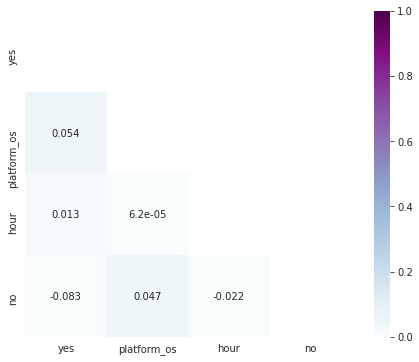

In [12]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(8, 6))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

correlation_map(df, 'yes', 4)

Like we expected, so no multicolinearity worries.

### 3.6 Feature Generation and Reduction

In [13]:
# Feature generation
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')  # convert date to datetime object
# df['day']=df['date'].dt.day                       #extract the day
df['dayofweek_num']=df['date'].dt.dayofweek       # extract the day of the week

# features reduction
df = df.drop(['date'], axis = 1)  #drop  the date col
df = df.drop(['auction_id'], axis = 1)  #drop  the auction_id col
df.tail(5)

,experiment,device_make,browser,hour,platform_os,yes,no,dayofweek_num
8072,exposed,Generic Smartphone,Chrome Mobile,7,6,0,0,6
8073,control,Generic Smartphone,Chrome Mobile,15,6,0,0,4
8074,control,Generic Smartphone,Chrome Mobile,9,6,0,0,5
8075,exposed,Samsung SM-A515F,Samsung Internet,15,6,0,0,6
8076,control,Samsung SM-G960F,Facebook,14,6,0,0,4


### 3.7 Remapping categorical variables


In [14]:
#check the datatypes
print(df.shape)
df.dtypes

(8077, 8)


experiment       object
device_make      object
browser          object
hour              int64
platform_os       int64
yes               int64
no                int64
dayofweek_num     int64
dtype: object

In [15]:
# get the location of the 3 categorical columns
features = df.copy()
indices = []
for col in ['browser', 'experiment', 'device_make']:
    k = features.columns.get_loc(col)
    indices.append(k)
    
indices

[2, 0, 1]

In [16]:
# Encoding categorical variables using Label Encoder
columns = indices
for col in columns:
    x = features.iloc[:, col].values
    x = x.reshape(-1,1)
    encoder = LabelEncoder()
    encoder = encoder.fit(x)
    x = encoder.transform(x)
    features.iloc[:, col] = x 

# features = pd.get_dummies(df)
print(features.shape)
features.head()

(8077, 8)


,experiment,device_make,browser,hour,platform_os,yes,no,dayofweek_num
0,1,46,2,8,6,0,0,4
1,1,46,2,10,6,0,0,1
2,1,29,3,2,6,0,1,6
3,0,137,6,15,6,0,0,4
4,0,46,2,15,6,0,0,4


## 4. Modelling

### 4.1 Train , Validation and Test Sets (70, 20, 10)
Predictor + target variables

In [17]:
# create the target variable from the yes/no cols then drop yes/no cols

# the 1s in yes remain the same, the 1s in no become 2s, the entries with 0s in both cols remain as 0s.
features['target'] = 0
features.loc[features['yes'] ==1, 'target'] = 1
features.loc[features['no'] ==1, 'target'] = 2
features = features.drop(['yes', 'no'], axis = 1)
# features = features[features.target != 0]
# features.loc[features['target'] ==2, 'target'] = 0
print(features.shape)
features.target.value_counts()

(8077, 7)


0    6834
2     671
1     572
Name: target, dtype: int64

In [18]:
features.head()

,experiment,device_make,browser,hour,platform_os,dayofweek_num,target
0,1,46,2,8,6,4,0
1,1,46,2,10,6,1,0
2,1,29,3,2,6,6,2
3,0,137,6,15,6,4,0
4,0,46,2,15,6,4,0


In [19]:
# dependent and independent variables
x = features.drop(['target'], axis = 1)
y = features[['target']]

# split dataset to train and test sets (90:10)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .1, random_state = 0)
print('x train', x_train.shape)
print('y train', y_train.shape)
print('x test', x_test.shape)
print('y test', y_test.shape)

x train (7269, 6)
y train (7269, 1)
x test (808, 6)
y test (808, 1)


In [20]:
# get the validation set from the train set (70:20)

# the % changes to 22 to be representative of the 20 expected originally
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = .22, random_state = 0)
print('x train', x_train.shape)
print('y train', y_train.shape)
print('x validation', x_val.shape)
print('y validation', y_val.shape)
print('x test', x_test.shape)
print('y test', y_test.shape)

x train (5669, 6)
y train (5669, 1)
x validation (1600, 6)
y validation (1600, 1)
x test (808, 6)
y test (808, 1)


### 4.2 Logistic Regression

**Logistic regression** is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [21]:
# create the regressor
regressor = LogisticRegression(solver = 'lbfgs', random_state=42)
regressor.fit(x_train, y_train)

scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
print(scores)
print("mean Logistic regression score : ", scores.mean())

[0.84038801 0.84038801 0.84038801 0.84038801 0.84024713]
mean Logistic regression score :  0.8403598319455925


In [22]:
# feature importance
feat_imp_dict = dict(zip(x_train.columns, regressor.coef_[0]))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False)

,FeatureImportance
platform_os,0.245862
device_make,0.001805
dayofweek_num,0.001700
hour,-0.000144
browser,-0.017899
experiment,-0.115166


In [23]:
# feature weights for every class
coef_0=regressor.coef_[0]
coef_1=regressor.coef_[1]
coef_2=regressor.coef_[2]
print(coef_0)
print(coef_1)
print(coef_2)

[-1.15165881e-01  1.80501937e-03 -1.78985548e-02 -1.44437583e-04
  2.45862116e-01  1.70020719e-03]
[ 7.88404298e-02  4.30507157e-05 -6.80950968e-03  9.41292926e-03
 -1.43883233e-01 -2.27142482e-02]
[ 0.03632545 -0.00184807  0.02470806 -0.00926849 -0.10197888  0.02101404]


### 4.3 XGB
**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.

[The documentation.](https://xgboost.readthedocs.io/en/latest/)

In [24]:
### XGB
xgb = XGBClassifier(random_state=42, )
xgb.fit(x_train, y_train)

scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
print(scores)
print("mean xgb score : ", scores.mean())

[0.84038801 0.84038801 0.84038801 0.84038801 0.84024713]
mean xgb score :  0.8403598319455925


In [25]:
# feature importance
feat_imp_dict = dict(zip(x_train.columns, xgb.feature_importances_))
feat_imp_2 = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp_2.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp_2.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
experiment,0.268051
device_make,0.254569
dayofweek_num,0.173090
browser,0.168532
hour,0.135758


### 4.4 Decision Trees

A **decision tree** is a decision support tool that uses a tree-like model of decisions and their possible consequences. It is one way to display an algorithm that only contains conditional control statements.

A **decision tree classifier** (Pang-Ning et al., 2006) creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute.


In [26]:
### dt
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

scores = cross_val_score(estimator = tree, X = x_train, y = y_train, cv = 5)
print(scores)
print("mean decision trees score : ", scores.mean())

[0.78659612 0.78659612 0.77601411 0.78835979 0.79082083]
mean decision trees score :  0.7856773934443837


In [27]:
# feature importance
feat_importance = tree.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(x_train.columns, tree.feature_importances_))
feat_imp_3 = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp_3.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp_3.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
hour,0.375665
device_make,0.329600
dayofweek_num,0.206457
browser,0.062996
experiment,0.025282


**experiment** appears twice in the top 5 most important features out of the 3 algorithms. 

### 4.5 Model Performance plot

Text(0.5, 1.0, 'barplot indicating model performances')

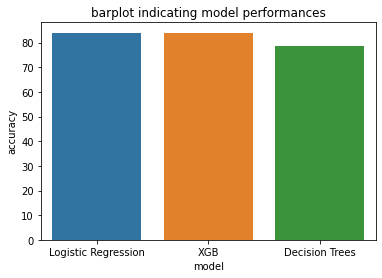

In [28]:
# create accuracies df then plot
data = {'accuracy': [0.8403598319455925 * 100,  0.8403598319455925 * 100,  0.7856773934443837 * 100], 
        'model': ['Logistic Regression' , 'XGB', 'Decision Trees']}
df = pd.DataFrame(data, columns = ['accuracy', 'model'])
# plot
plt.figure(figsize = (6,4))
sns.barplot(y = df.accuracy, x = df.model)
plt.title('barplot indicating model performances')

### 4.6 Loss Functions

It’s a method of evaluating how well an algorithm models the given data. If predictions deviates too much from actual results, loss function will be high.

In [29]:
# log loss for logistic regression
probabilities = regressor.predict_proba(x_val)
# calculate log loss
loss = log_loss(y_val, probabilities)
loss

0.519512717164833

In [30]:
# log loss for xgb
probabilities = xgb.predict_proba(x_val)
# calculate log loss
loss = log_loss(y_val, probabilities)
loss

0.5132259370622342

In [31]:
# log loss for dt
probabilities = tree.predict_proba(x_val)
# calculate log loss
loss = log_loss(y_val, probabilities)
loss

4.914874985480904

### 4.7 Loss Plots

Text(0.5, 1.0, 'barplot indicating loss functions for different models')

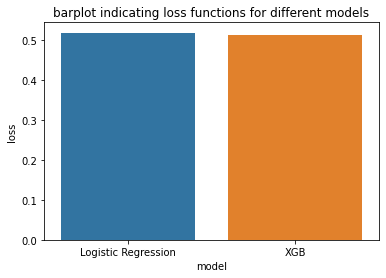

In [32]:
# create accuracies df then plot
data = {'loss': [0.519512717164833,  0.5132259370622342], 
        'model': ['Logistic Regression' , 'XGB']}
df = pd.DataFrame(data, columns = ['loss', 'model'])
# plot
plt.figure(figsize = (6,4))
sns.barplot(y = df.loss, x = df.model)
plt.title('barplot indicating loss functions for different models')

### 4.8 Feature Importance Plots

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

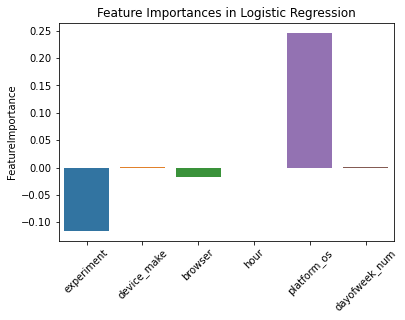

In [33]:
# LR
plt.figure(figsize = (6,4))
sns.barplot(y = feat_imp.FeatureImportance, x = feat_imp.index)
plt.title('Feature Importances in Logistic Regression')
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

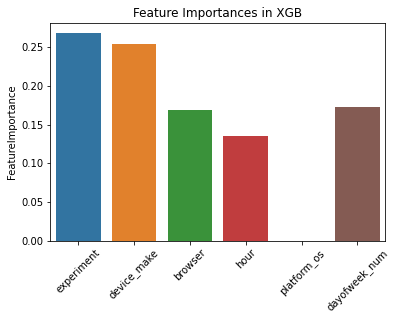

In [34]:
# XGB
plt.figure(figsize = (6,4))
sns.barplot(y = feat_imp_2.FeatureImportance, x = feat_imp_2.index)
plt.title('Feature Importances in XGB')
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

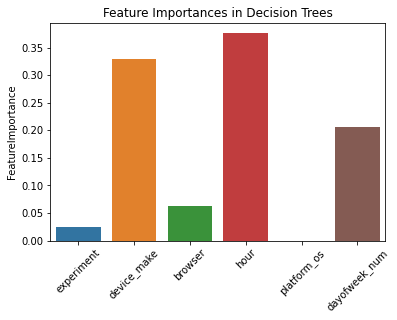

In [35]:
# DT
plt.figure(figsize = (6,4))
sns.barplot(y = feat_imp_3.FeatureImportance, x = feat_imp_3.index)
plt.title('Feature Importances in Decision Trees')
plt.xticks(rotation = 45)

### 4.8 Predictions

In [50]:
# using Decision Tree to run predictions on x_test
y_pred = tree.predict(x_test)
a = pd.DataFrame(y_pred)
a.columns = ['pred']
a.pred.value_counts()

0    754
2     27
1     27
Name: pred, dtype: int64

In [51]:
!pip freeze > requirements.txt